In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import pickle
import glob 
import timeit
from itertools import product
import matplotlib.colors as mcolors

data_path = os.path.join("data")
fits_path = os.path.join("modelfits")
figpath = os.path.join("fig")

import sys
print(sys.version)

alpha_val = 0.3

3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]


In [7]:
n_folds = 5
cv_seed = 0

logistic_growth = lambda t, theta: theta[:,0] + theta[:,1]/(1+np.exp(-theta[:,2]*(t-theta[:,3])))
dt=1  #1
ts = np.arange(0,11,dt)[:,None]
T_ends = [10,10]

In [8]:
# 1) Functions for model fitting
logistic_growth = lambda t, theta: theta[:,0] + theta[:,1]/(1+np.exp(-theta[:,2]*(t-theta[:,3])))
dt=1  #1
ts = np.arange(0,11,dt)[:,None]
T_end = len(ts)-1;

# Group-level parameters for each family
theta_mean = 0.55
theta_nu = 0.15
condition_left_offsets = np.array([17-25/24, 3]) # Offsets for the seplate and sepearly conditions.

def logistic_growth_group(ts, traj_assymtotes, left_offset):
    '''Here, theta is a num_thetas x 1 vector, 
    corresponding to theta[:,1] required by the lambda function logistic_growth().'''
    num_thetas,_ = traj_assymtotes.shape
    new_theta = np.zeros((num_thetas,4))
    new_theta[:,0] = 0 # Starting height
    new_theta[:,1] = np.squeeze(traj_assymtotes) # Asymptotic height
    new_theta[:,2] = -1/2*np.squeeze(traj_assymtotes) + 9/8 # Slope
    new_theta[:,3] = left_offset + 25/6*np.squeeze(traj_assymtotes) # Left/right translation
    return logistic_growth(3*ts, new_theta)

def log_normpdf(x, mean, std):
    log_normpdf_unnorm = -np.log(std)-0.5*np.log(2*np.pi)-0.5*((x-mean)/std)**2
    return log_normpdf_unnorm

## Grid of integration. Needs to be more finer. 
theta0_grid = np.linspace(0,1,50)  
r_T_grid = np.linspace(-3,5,400)

def traj_r_T_estimation(ts, rs_traj, sensory_noise=0.1, cond=0, t_now_idx=0, T_end=T_end):
    ts_train = ts[0:(t_now_idx+1)];

    # 1) Find p(theta|r) as a function of theta.
    log_p_thetaj_given_rj = log_normpdf(theta0_grid,theta_mean,theta_nu) # This is actually the log prior p(theta); [theta0_grid]
    rho_t_given_thetaj = logistic_growth_group(ts_train, theta0_grid[:,None], condition_left_offsets[cond]) # traj heights over time, given theta [ts_train, theta0_grid]
    if(t_now_idx>-1):
        # Update the prior p(theta) using the likelihoods over time p(r_{1:t} | theta), to obtain the posterior p(theta | r_{1:t})
        log_p_thetaj_given_rj = log_p_thetaj_given_rj + np.sum(log_normpdf(rho_t_given_thetaj, rs_traj[0:len(ts_train)][:,None], sensory_noise), axis=0) # np.sum is summing across time over log likelihoods
    # logsumexp
    log_p_thetaj_given_rj_normalized = log_p_thetaj_given_rj - scipy.special.logsumexp(log_p_thetaj_given_rj)


    # 2) Find p(r_T | rho(T; theta))
    rho_T_given_thetaj = logistic_growth_group(T_end, theta0_grid[:,None], condition_left_offsets[cond]) #[theta0_grid, ]
    log_r_T_given_thetaj = log_normpdf(r_T_grid[:,None], rho_T_given_thetaj[None,:], sensory_noise) # [r_T_grid, theta0_grid]

    # 3) Find p(r_T | r)
    log_p_r_T_and_theta_given_r = log_r_T_given_thetaj + log_p_thetaj_given_rj_normalized[None,:]
    p_r_T_given_r = np.trapz(np.exp(log_p_r_T_and_theta_given_r), x=theta0_grid, axis=-1)
    p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
    post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)
    return post_mean

p_stay_logistic = lambda diff, slope, offset: 1 / (1 + np.exp(offset - slope * diff))

def prob_stay_logistic(theta, cond=0, ts=ts, t_now=0, T_end=T_end, traj=np.nan, model="bayesian_postmean", include_offset_param = True, return_postmean=False):
    '''Given a set of parameter values theta=(sensory_noise, slope, offset), 
        evaluate p(stay; theta, traj[0:(t_now+1)]) given the starting trajectory's development up until t_now, 
        under a certain model.'''
    sensory_noise = theta[0]
    slope = theta[1]
    if(include_offset_param):
        offset = theta[2]
    else:
        offset = 0

    if(model=="bayesian_postmean"):
        stay_finalheight_postmean = traj_r_T_estimation(ts, traj, sensory_noise=sensory_noise, cond=cond, t_now_idx=t_now, T_end=T_end)
        switch_finalheight_priormean = traj_r_T_estimation(ts, np.nan, sensory_noise=sensory_noise, cond=cond, t_now_idx=-1, T_end=ts[T_end-t_now][0])
        final_height_diff = stay_finalheight_postmean - switch_finalheight_priormean
        prob_stay = p_stay_logistic(final_height_diff, slope, offset)
        if(return_postmean):
            return (prob_stay, final_height_diff)

    elif(model=="velocity"):
        stay_finalheight_postmean = traj_r_T_estimation(ts, traj, sensory_noise=sensory_noise, cond=cond, t_now_idx=t_now, T_end=T_end)
        switch_finalheight_priormean = traj_r_T_estimation(ts, np.nan, sensory_noise=sensory_noise, cond=cond, t_now_idx=-1, T_end=ts[T_end-t_now][0])  
        stay_initial_height_postmean = traj_r_T_estimation(ts, traj, sensory_noise=sensory_noise, cond=cond, t_now_idx=t_now, T_end=t_now)
        switch_initial_height_priormean = traj_r_T_estimation(ts, np.nan, sensory_noise=sensory_noise, cond=cond, t_now_idx=-1, T_end=0)

        stay_velocity = (stay_finalheight_postmean - stay_initial_height_postmean)/(T_end-t_now)
        switch_velocity = (switch_finalheight_priormean - switch_initial_height_priormean)/(T_end-t_now)
        velocity_diff = stay_velocity - switch_velocity
        prob_stay = p_stay_logistic(velocity_diff, slope, offset)
        if(return_postmean):
            return (prob_stay, velocity_diff)

    elif(model=="exploitation_heuristic"):
#         stay_currentheight = traj[t_now]
#         switch_initial_height_priormean = traj_r_T_estimation(ts, np.nan, sensory_noise=sensory_noise, cond=cond, t_now_idx=-1, T_end=0)
#         current_height_diff = stay_currentheight - switch_initial_height_priormean
#         prob_stay = p_stay_logistic(current_height_diff, slope, offset)
        prob_stay = p_stay_logistic(traj[t_now], slope, offset)
        if(return_postmean):
            return (prob_stay, traj[t_now])

    elif(model=="velocity_heuristic"):
        velocity_diff = (traj[t_now]- traj[t_now-1]) - (traj[t_now]-traj[0])/(t_now)
        prob_stay = p_stay_logistic(velocity_diff, slope, offset)
        if(return_postmean):
            return (prob_stay, velocity_diff)



    return prob_stay



T_ends = [10,10]

def crossentropy_loss(theta, data_subj=np.nan, ts=ts, T_ends=T_ends, model="bayesian_postmean",include_offset_param=True, cross_validate=False, cross_validate_timepts=np.nan):
    '''For the data of one subject: [cond, run, t_now, (traj_height, response)],
    and a set of parameter values theta, compute cross entropy loss.'''

    loss = 0;
    for cond in range(n_conds):
        T_end = T_ends[cond]
        for run in range(n_runs):
            traj = data_subj[cond,run,:,0]
            responses = data_subj[cond,run,:,1] # 1 is stay; 0 is switch
            n_steps_beforeswitch = np.sum(1-np.isnan(responses))
            for t_now_idx in range(1,n_steps_beforeswitch+1): # Exclude Month 0, and any month after the switch (if switched)

                if(cross_validate): # Doing cross-validation: only evaluate loss on a subset of dpts.
                    target_tuple = (cond,run,t_now_idx)

                    if(target_tuple in cross_validate_timepts):
                        model_prob_pred = prob_stay_logistic(theta, cond=cond, traj=traj, ts=ts, t_now=ts[t_now_idx][0], T_end=T_end, model=model,include_offset_param=include_offset_param)
                        response = responses[t_now_idx]
                        if(response==1):
                            loss = loss - np.log(max(model_prob_pred,1e-100))
                        elif(response==0):
                            loss = loss - np.log(max(1-model_prob_pred,1e-100))
                        else:
                            print("Warning: CV trials include nan!")
                    else: 
                        continue;

                else: # Not doing cross-validation: fitted to the full dataset.
                    model_prob_pred = prob_stay_logistic(theta, cond=cond, traj=traj, ts=ts, t_now=ts[t_now_idx][0], T_end=T_end, model=model,include_offset_param=include_offset_param)
                    response = responses[t_now_idx]
                    if(response==1):
                        loss = loss - np.log(max(model_prob_pred,1e-100))
                    elif(response==0):
                        loss = loss - np.log(max(1-model_prob_pred,1e-100))
                    else:
                        print("Warning: trials include nan!")
    return loss


def evaluate_p_stay_logistic(theta, data_subj=np.nan, ts=ts, T_ends=T_ends, model="bayesian_postmean",include_offset_param=True):   
    loss = 0;
    model_prob_preds = np.zeros((n_conds, n_runs, n_timesteps))
    model_prob_preds[:] = np.nan;
    stayswitch_diffs = np.zeros((n_conds, n_runs, n_timesteps))
    stayswitch_diffs[:] = np.nan;
    for cond in range(n_conds):
        T_end = T_ends[cond]
        for run in range(n_runs):
            traj = data_subj[cond,run,:,0]
            responses = data_subj[cond,run,:,1] # 1 is stay; 0 is switch
            n_steps_beforeswitch = np.sum(1-np.isnan(responses))
            for t_now_idx in range(1,n_steps_beforeswitch+1): # Exclude Month 0, and any month after the switch (if switched)
                [model_prob_pred, stayswitch_diff] = prob_stay_logistic(theta, cond=cond, traj=traj, ts=ts, t_now=ts[t_now_idx][0], T_end=T_end, model=model, return_postmean=True,include_offset_param=include_offset_param)
                model_prob_preds[cond, run, t_now_idx] = model_prob_pred
                stayswitch_diffs[cond, run, t_now_idx] = stayswitch_diff
    return (model_prob_preds, stayswitch_diffs)


def cross_validation_dataset_partition(responses_allsubj, n_folds=5, seed=0):
    # Cross validation dataset partitioning?
    n_subj = responses_allsubj.shape[1] # [conds, subj, runs, timepts]
    cross_val_setidxs_allsubj = [] # Nested array: subjs -> folds -> (train dataset, test dataset) -> [cond,run,timept] signatures of a trial.

    for subj in range(n_subj):
        responses = responses_allsubj[:,subj,:,:]

        # Step 1: Identify valid trials (0 or 1)
        valid_indices = np.argwhere((responses == 0) | (responses == 1))

        # Step 2: Shuffle indices
        np.random.seed(seed)
        np.random.shuffle(valid_indices)

        # Step 3: Split into 5 folds
        folds = np.array_split(valid_indices, n_folds)

        # Step 4: Create training and testing trial idxs for each fold
        cross_val_setidxs = []
        for i in range(n_folds):
            test_indices = folds[i]
            train_indices = np.concatenate(folds[:i] + folds[i+1:])
            train_indices = [tuple(idx) for idx in train_indices]
            test_indices = [tuple(idx) for idx in test_indices]
            cross_val_setidxs.append((train_indices, test_indices)) # First level are the 5 folds; second level is a tuple with [0] being the training dataset.
        cross_val_setidxs_allsubj.append(cross_val_setidxs)

    return cross_val_setidxs_allsubj

In [9]:
def decompose_model_fullname(model_fullname):
    include_offset_param = "_offset" in model_fullname
    model = model_fullname.rpartition('_')[0]
    return (model, include_offset_param)

In [10]:
# 2) Load the fake datasets for all models
filename = os.path.join(data_path, "exp3_fits_fakedata_allmodels")
with open(filename+'.pickle', 'rb') as handle:
    b = pickle.load(handle)
models_true_gen_params = b['true_gen_params']
models_fakedata = b['models_fakedata']
[n_conds, n_subj, n_runs, n_timepts, _] = models_fakedata["bayesian_postmean_offset"].shape

print(models_true_gen_params["velocity_offset"].shape)
# CV dataset partition: Loop over fake datasets to fit models on.
cross_val_setidxs_allsubjs_fakedata = {}
for fake_dataset_genmodel in models_fakedata.keys():
    fake_dataset = models_fakedata[fake_dataset_genmodel]
    cross_val_setidxs_allsubjs_fakedata[fake_dataset_genmodel] = cross_validation_dataset_partition(fake_dataset[:,:,:,:,1], n_folds, cv_seed)
# Print length of train and test dataset for a particular subj's particular fold.
print("Fake datasets loaded and CV-partitioned: n_folds="+str(n_folds)+", seed="+str(cv_seed))


# Get fakedataset_modelfullname_pairs.
model_fullnames = [key for key in models_fakedata.keys()]
# Convert to JSON-formatted string with double quotes
#model_fullnames = json.dumps(model_fullnames, indent=2)
fakedataset_modelfullname_pairs = list(product(model_fullnames, repeat=2))
print(fakedataset_modelfullname_pairs[58])

(80, 3)
Fake datasets loaded and CV-partitioned: n_folds=5, seed=0
('velocity_heuristic_nooffset', 'exploitation_heuristic_offset')


## Fake dataset generation

In [11]:
# Load the human dataset
filename = "exp3_data"
with open(os.path.join(data_path, filename)+'.pickle', 'rb') as handle:
    b = pickle.load(handle)
print(b.keys())  
mturk_IDs = b["mturk_IDs"]
data = b['data']
traj_params = b["traj_params"]
traj_finalheights = b["counterfactual_traj_finalheights"]
starting_traj_heights_counterfactual = b["starting_traj_heights_counterfactual"]
(n_conds,n_subj,n_runs,n_timesteps,_) = data.shape

dict_keys(['mturk_IDs', 'data_dims', 'data', 'traj_params', 'counterfactual_traj_finalheights', 'starting_traj_heights_counterfactual', 'ages', 'genders', 'comments'])


C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3664597272.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  b = pickle.load(handle)


In [18]:
model_fullnames = ["bayesian_postmean_offset","velocity_offset", "exploitation_heuristic_offset","velocity_heuristic_offset","bayesian_postmean_nooffset","velocity_nooffset", "exploitation_heuristic_nooffset","velocity_heuristic_nooffset"]
best_params_fitted = {}
models_fakedata_probstay = {}

# Assume subjects always stay, to allow for logistic prob evaluation.
data_staycounterfactual = data.copy()
data_staycounterfactual[:,:,:,:,0] = starting_traj_heights_counterfactual
data_staycounterfactual[:,:,:,:,1] = 1
data_staycounterfactual[:,:,:,0,1] = np.nan # Subjects cannot switch at t=0
#print(data_staycounterfactual[:,:,:,:,0])

for model_idx in range(len(model_fullnames)):
    model_fullname = model_fullnames[model_idx]
    print(model_fullname)
    (model, include_offset_param) = decompose_model_fullname(model_fullname)
    
    filename = "exp3_fits__d_human__m_"+model_fullname
    with open(os.path.join(fits_path, filename)+'.pickle', 'rb') as handle:
        b = pickle.load(handle)
    best_params_fitted_model = b["best_params_fitted"]
    print(b["params_fitted"].shape)
    best_params_fitted[model_fullname] = best_params_fitted_model[:,0,0,:]
    #print(best_params_fitted[model_fullname].shape)
    
    model_prob_preds_allsubj = np.zeros((n_conds, n_subj, n_runs, n_timesteps))
    for subj in range(n_subj): #min(n_subj,n_rows*n_cols)
        print(model_fullname, subj)
        data_subj = data_staycounterfactual[:,subj,:,:,:]
        params_fitted_temp = best_params_fitted_model[subj,0,0,:]
        [model_prob_preds,stayswitchdiff] = evaluate_p_stay_logistic(params_fitted_temp, data_subj=data_subj, ts=ts, T_ends=T_ends, model=model,include_offset_param=include_offset_param)
        model_prob_preds_allsubj[:,subj,:,:] = model_prob_preds

    models_fakedata_probstay[model_fullname] = model_prob_preds_allsubj

bayesian_postmean_offset
(80, 1, 10, 3)
bayesian_postmean_offset 0


C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = np.trapz(np.exp(log_p_r_T_and_theta_given_r), x=theta0_grid, axis=-1)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)


bayesian_postmean_offset 1
bayesian_postmean_offset 2
bayesian_postmean_offset 3
bayesian_postmean_offset 4
bayesian_postmean_offset 5
bayesian_postmean_offset 6
bayesian_postmean_offset 7
bayesian_postmean_offset 8
bayesian_postmean_offset 9
bayesian_postmean_offset 10
bayesian_postmean_offset 11
bayesian_postmean_offset 12
bayesian_postmean_offset 13
bayesian_postmean_offset 14
bayesian_postmean_offset 15
bayesian_postmean_offset 16
bayesian_postmean_offset 17
bayesian_postmean_offset 18
bayesian_postmean_offset 19
bayesian_postmean_offset 20
bayesian_postmean_offset 21
bayesian_postmean_offset 22
bayesian_postmean_offset 23
bayesian_postmean_offset 24
bayesian_postmean_offset 25
bayesian_postmean_offset 26
bayesian_postmean_offset 27
bayesian_postmean_offset 28
bayesian_postmean_offset 29
bayesian_postmean_offset 30
bayesian_postmean_offset 31
bayesian_postmean_offset 32
bayesian_postmean_offset 33
bayesian_postmean_offset 34
bayesian_postmean_offset 35
bayesian_postmean_offset 36
b

velocity_heuristic_offset 62
velocity_heuristic_offset 63
velocity_heuristic_offset 64
velocity_heuristic_offset 65
velocity_heuristic_offset 66
velocity_heuristic_offset 67
velocity_heuristic_offset 68
velocity_heuristic_offset 69
velocity_heuristic_offset 70
velocity_heuristic_offset 71
velocity_heuristic_offset 72
velocity_heuristic_offset 73
velocity_heuristic_offset 74
velocity_heuristic_offset 75
velocity_heuristic_offset 76
velocity_heuristic_offset 77
velocity_heuristic_offset 78
velocity_heuristic_offset 79
bayesian_postmean_nooffset
(80, 1, 10, 2)
bayesian_postmean_nooffset 0
bayesian_postmean_nooffset 1
bayesian_postmean_nooffset 2
bayesian_postmean_nooffset 3
bayesian_postmean_nooffset 4
bayesian_postmean_nooffset 5
bayesian_postmean_nooffset 6
bayesian_postmean_nooffset 7
bayesian_postmean_nooffset 8
bayesian_postmean_nooffset 9
bayesian_postmean_nooffset 10
bayesian_postmean_nooffset 11
bayesian_postmean_nooffset 12
bayesian_postmean_nooffset 13
bayesian_postmean_nooffset

velocity_heuristic_nooffset 28
velocity_heuristic_nooffset 29
velocity_heuristic_nooffset 30
velocity_heuristic_nooffset 31
velocity_heuristic_nooffset 32
velocity_heuristic_nooffset 33
velocity_heuristic_nooffset 34
velocity_heuristic_nooffset 35
velocity_heuristic_nooffset 36
velocity_heuristic_nooffset 37
velocity_heuristic_nooffset 38
velocity_heuristic_nooffset 39
velocity_heuristic_nooffset 40
velocity_heuristic_nooffset 41
velocity_heuristic_nooffset 42
velocity_heuristic_nooffset 43
velocity_heuristic_nooffset 44
velocity_heuristic_nooffset 45
velocity_heuristic_nooffset 46
velocity_heuristic_nooffset 47
velocity_heuristic_nooffset 48
velocity_heuristic_nooffset 49
velocity_heuristic_nooffset 50
velocity_heuristic_nooffset 51
velocity_heuristic_nooffset 52
velocity_heuristic_nooffset 53
velocity_heuristic_nooffset 54
velocity_heuristic_nooffset 55
velocity_heuristic_nooffset 56
velocity_heuristic_nooffset 57
velocity_heuristic_nooffset 58
velocity_heuristic_nooffset 59
velocity

In [19]:
models_fakedata = {}
# for include_offset_param in [True, False]:
for model_idx in range(len(model_fullnames)):
    np.random.seed(0) # Set seed for reproducibility.
    
    model_fullname = model_fullnames[model_idx]
    print(model_fullname)
    (model, include_offset_param) = decompose_model_fullname(model_fullname)
    model_fakedata_allsubj = data_staycounterfactual.copy() # ["condition (0 is separate late)","subject","run","timestep (Month 0 to 9)","data (current trajectory height, current decision)"]

    for subj in range(n_subj): #min(n_subj,n_rows*n_cols)
        model_fakedata_probstay_subj = models_fakedata_probstay[model_fullname][:,subj,:,1:] # [cond,run,n_timesteps]. Need to leave out timestep 0, which subjects cannot switch.
        model_fakedata_responses_subj = np.random.binomial(n=1, p=model_fakedata_probstay_subj)
        model_fakedata_allsubj[:,subj,:,1:,1] = model_fakedata_responses_subj.astype(int)

    # Account for the fact that agent can switch only once at most per trial.
    for cond in range(n_conds):
        for subj in range(n_subj):
            for run in range(n_runs):
                for t in range(1,n_timesteps): # Need to leave out timestep 0, which subjects cannot switch.
                    if(model_fakedata_allsubj[cond,subj,run,t,1]<0.5): # Subject switched on this trial
                        model_fakedata_allsubj[cond,subj,run,(t+1):,:] = np.nan # All later timesteps of this trial have values np.nan.

    models_fakedata[model_fullname] = model_fakedata_allsubj

bayesian_postmean_offset
velocity_offset
exploitation_heuristic_offset
velocity_heuristic_offset
bayesian_postmean_nooffset
velocity_nooffset
exploitation_heuristic_nooffset
velocity_heuristic_nooffset


In [26]:
# # Save the fake datasets for model recovery

# filename = "exp3_fits_fakedata_allmodels"
# a = {'true_gen_params':best_params_fitted, 'models_fakedata_probstay':models_fakedata_probstay, 'mturk_IDs': mturk_IDs, 'data_dims': ["condition (0 is separate late)","subject","run","timestep (Month 0 to 9)","data (current trajectory height, current decision)"], 'models_fakedata': models_fakedata}
# with open(os.path.join(data_path,filename)+'.pickle', 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

bayesian_postmean_offset


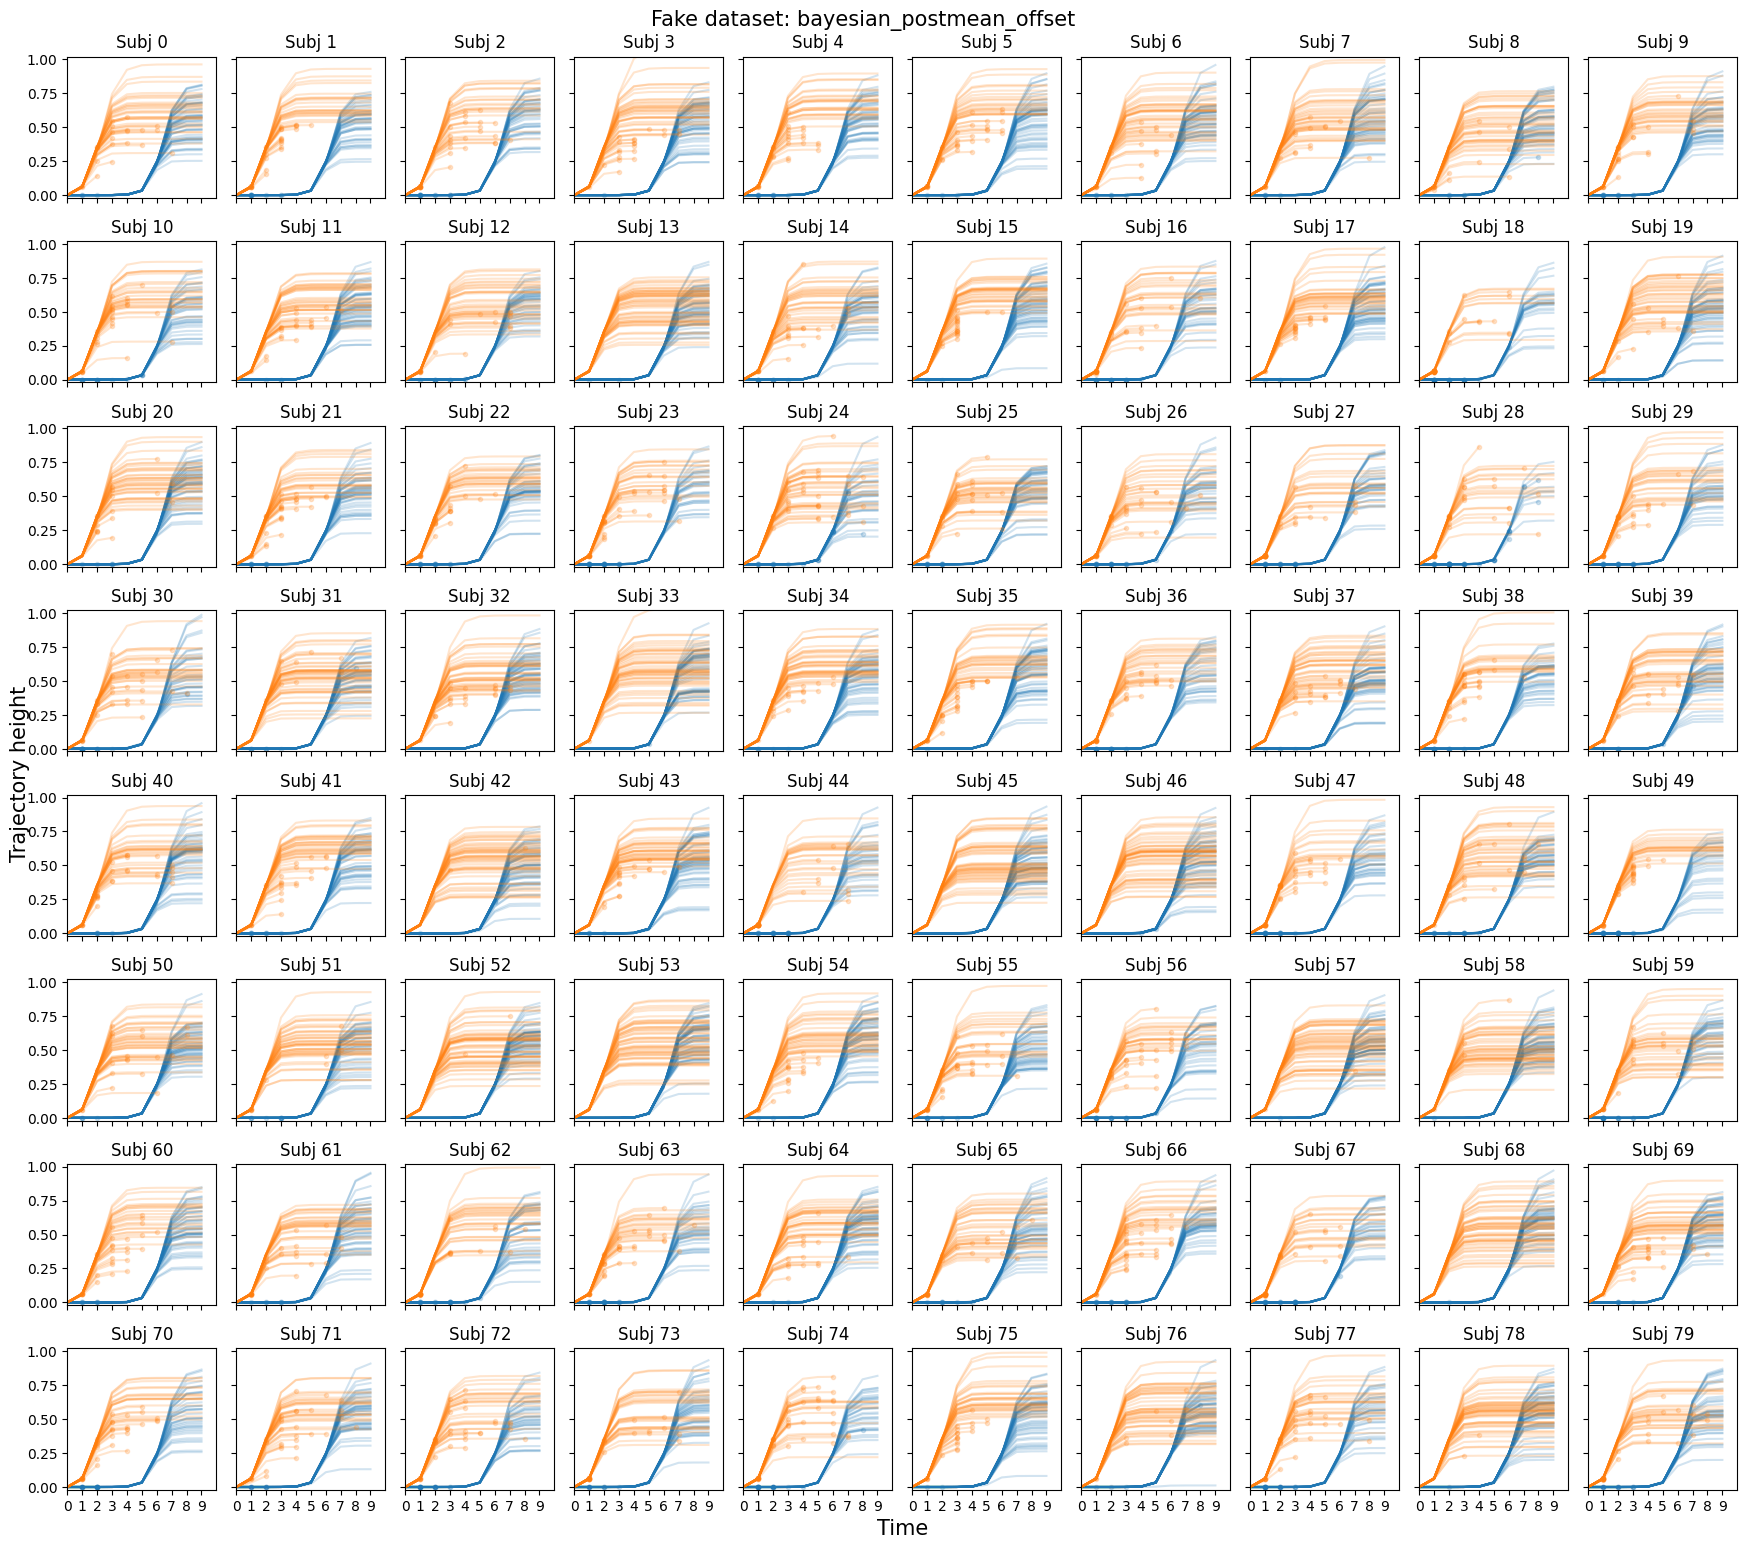

velocity_offset


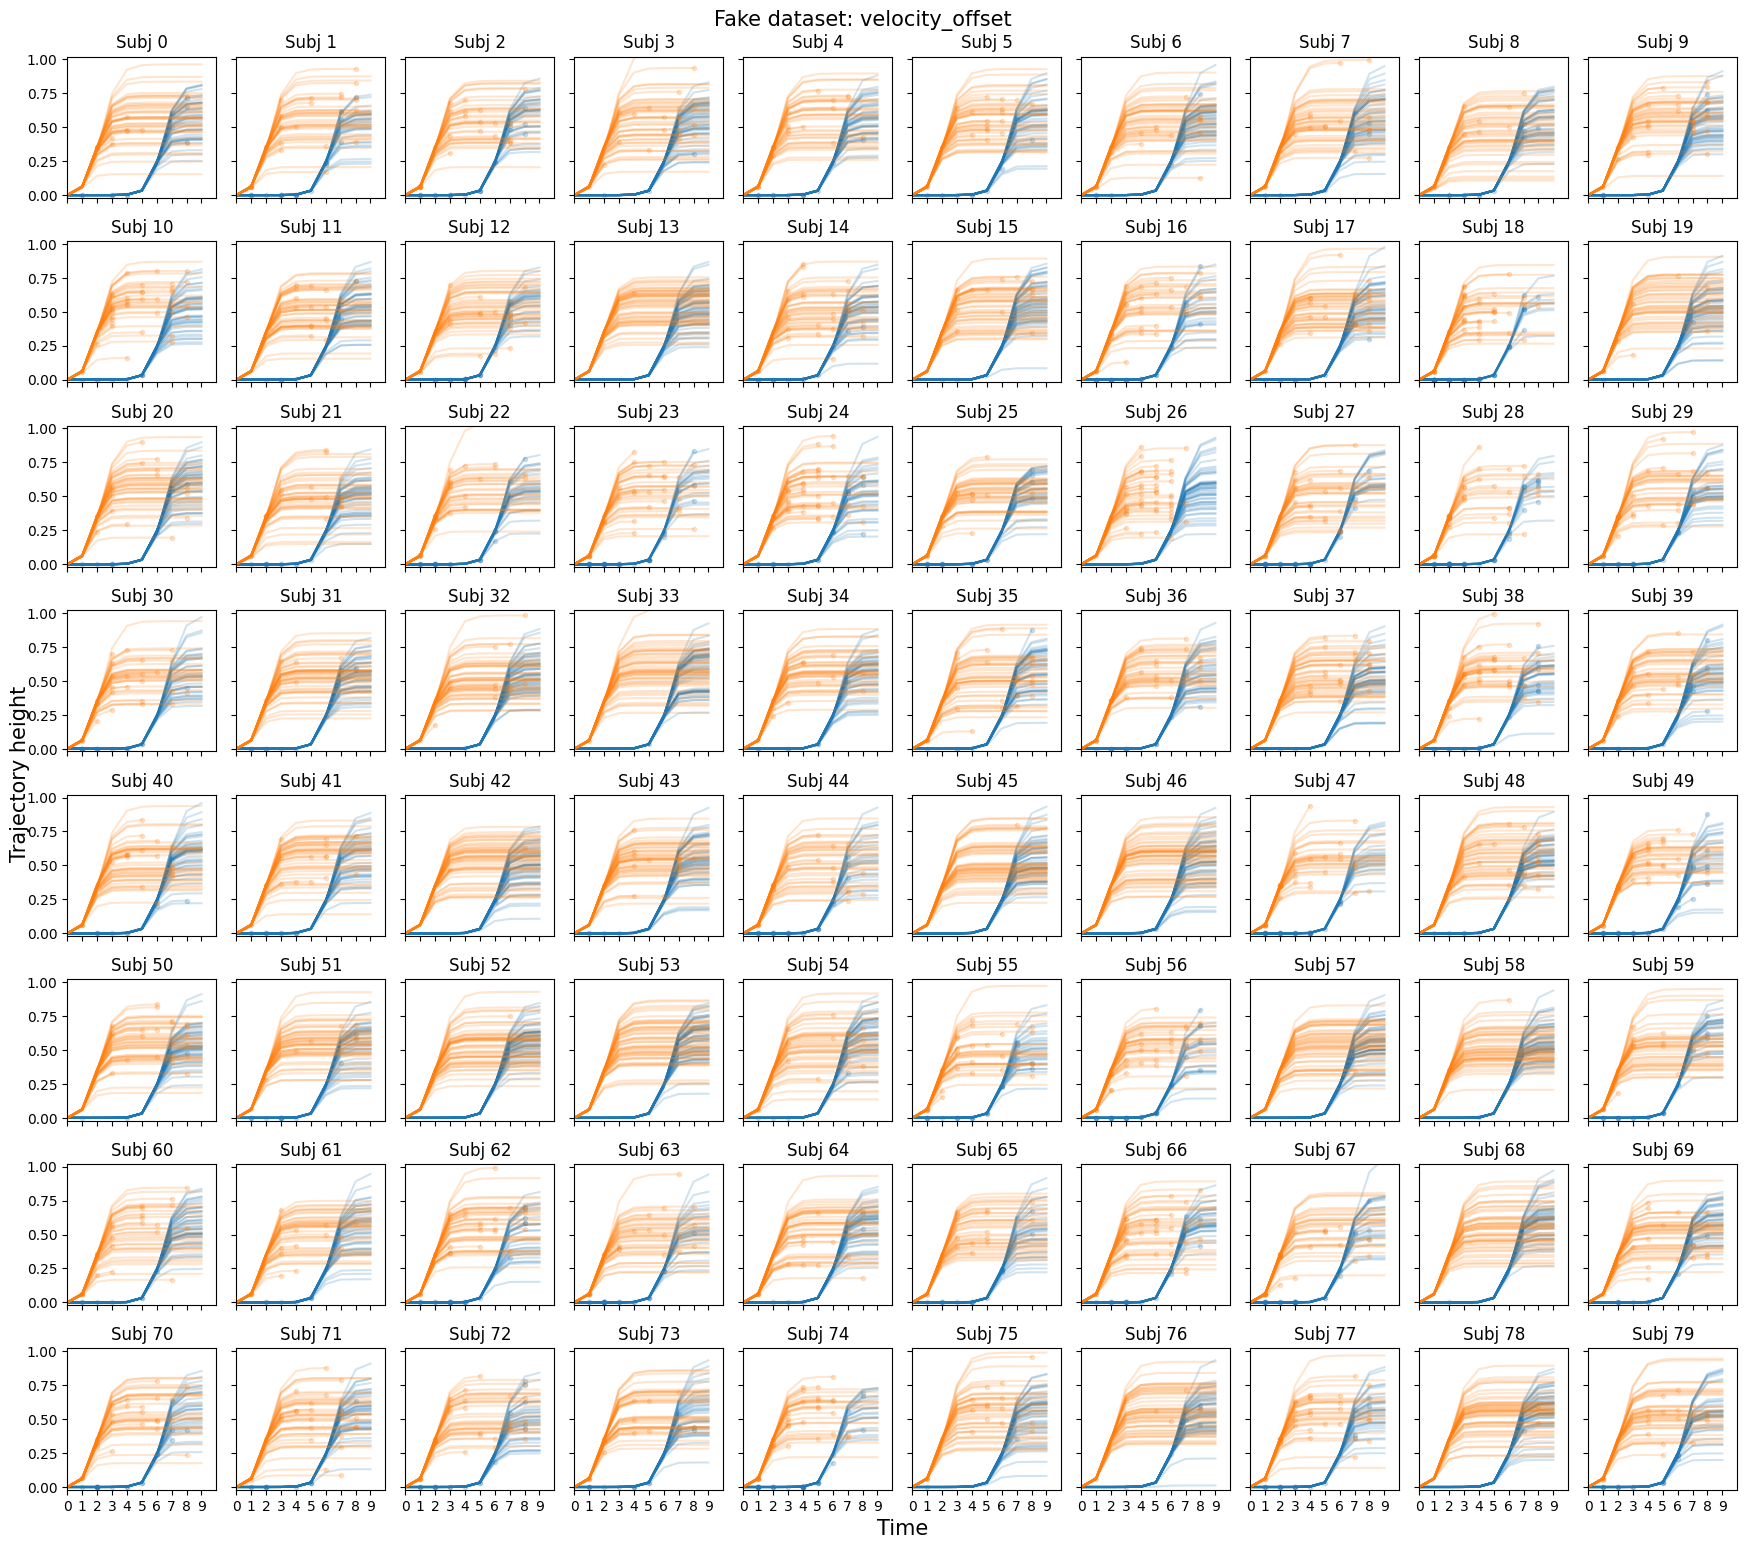

exploitation_heuristic_offset


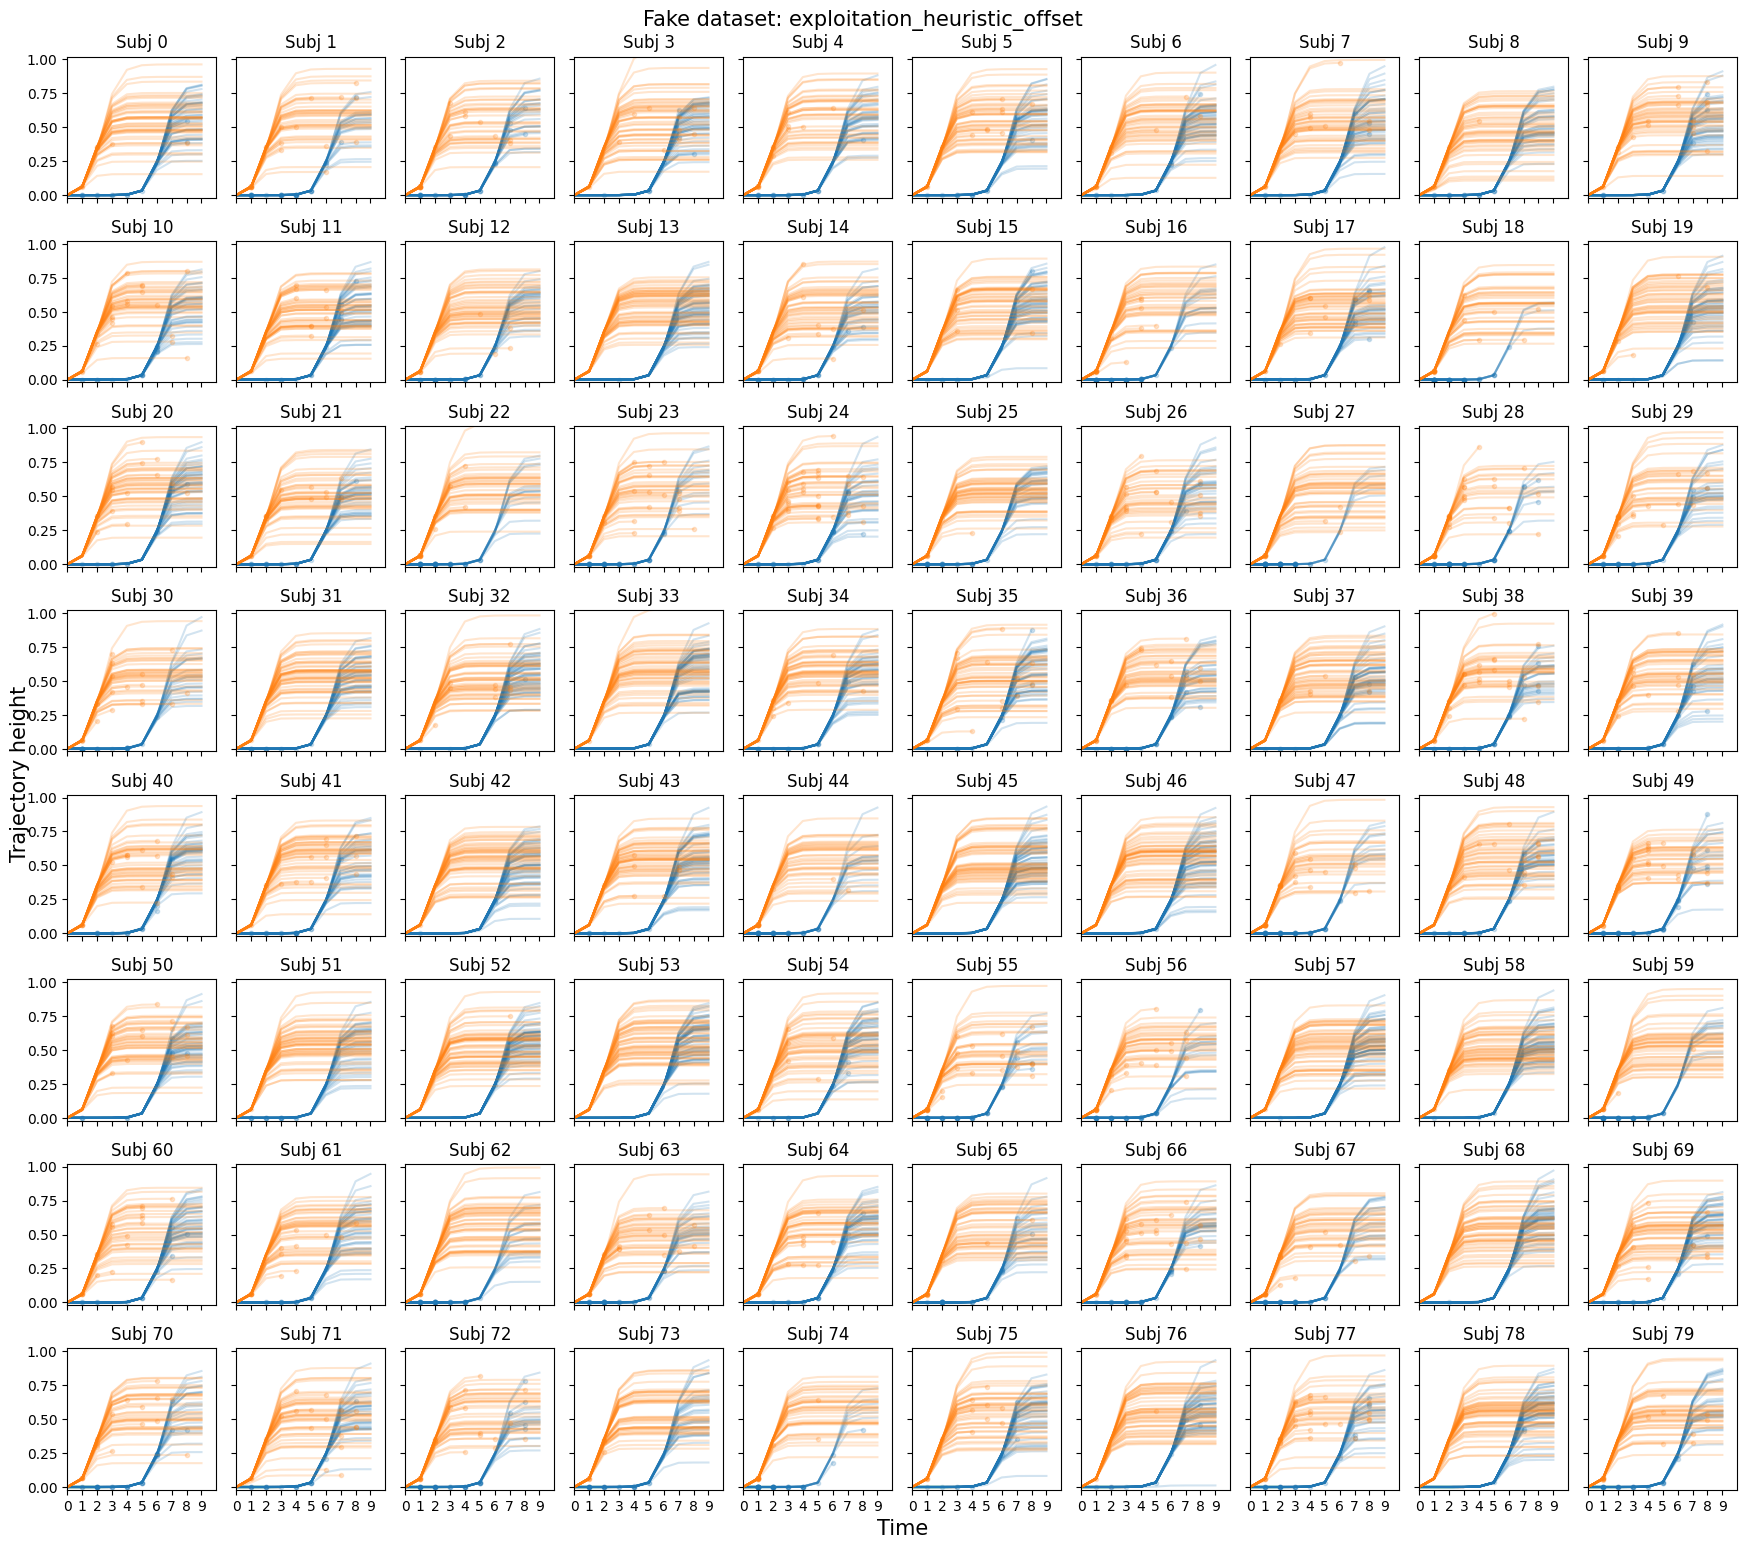

velocity_heuristic_offset


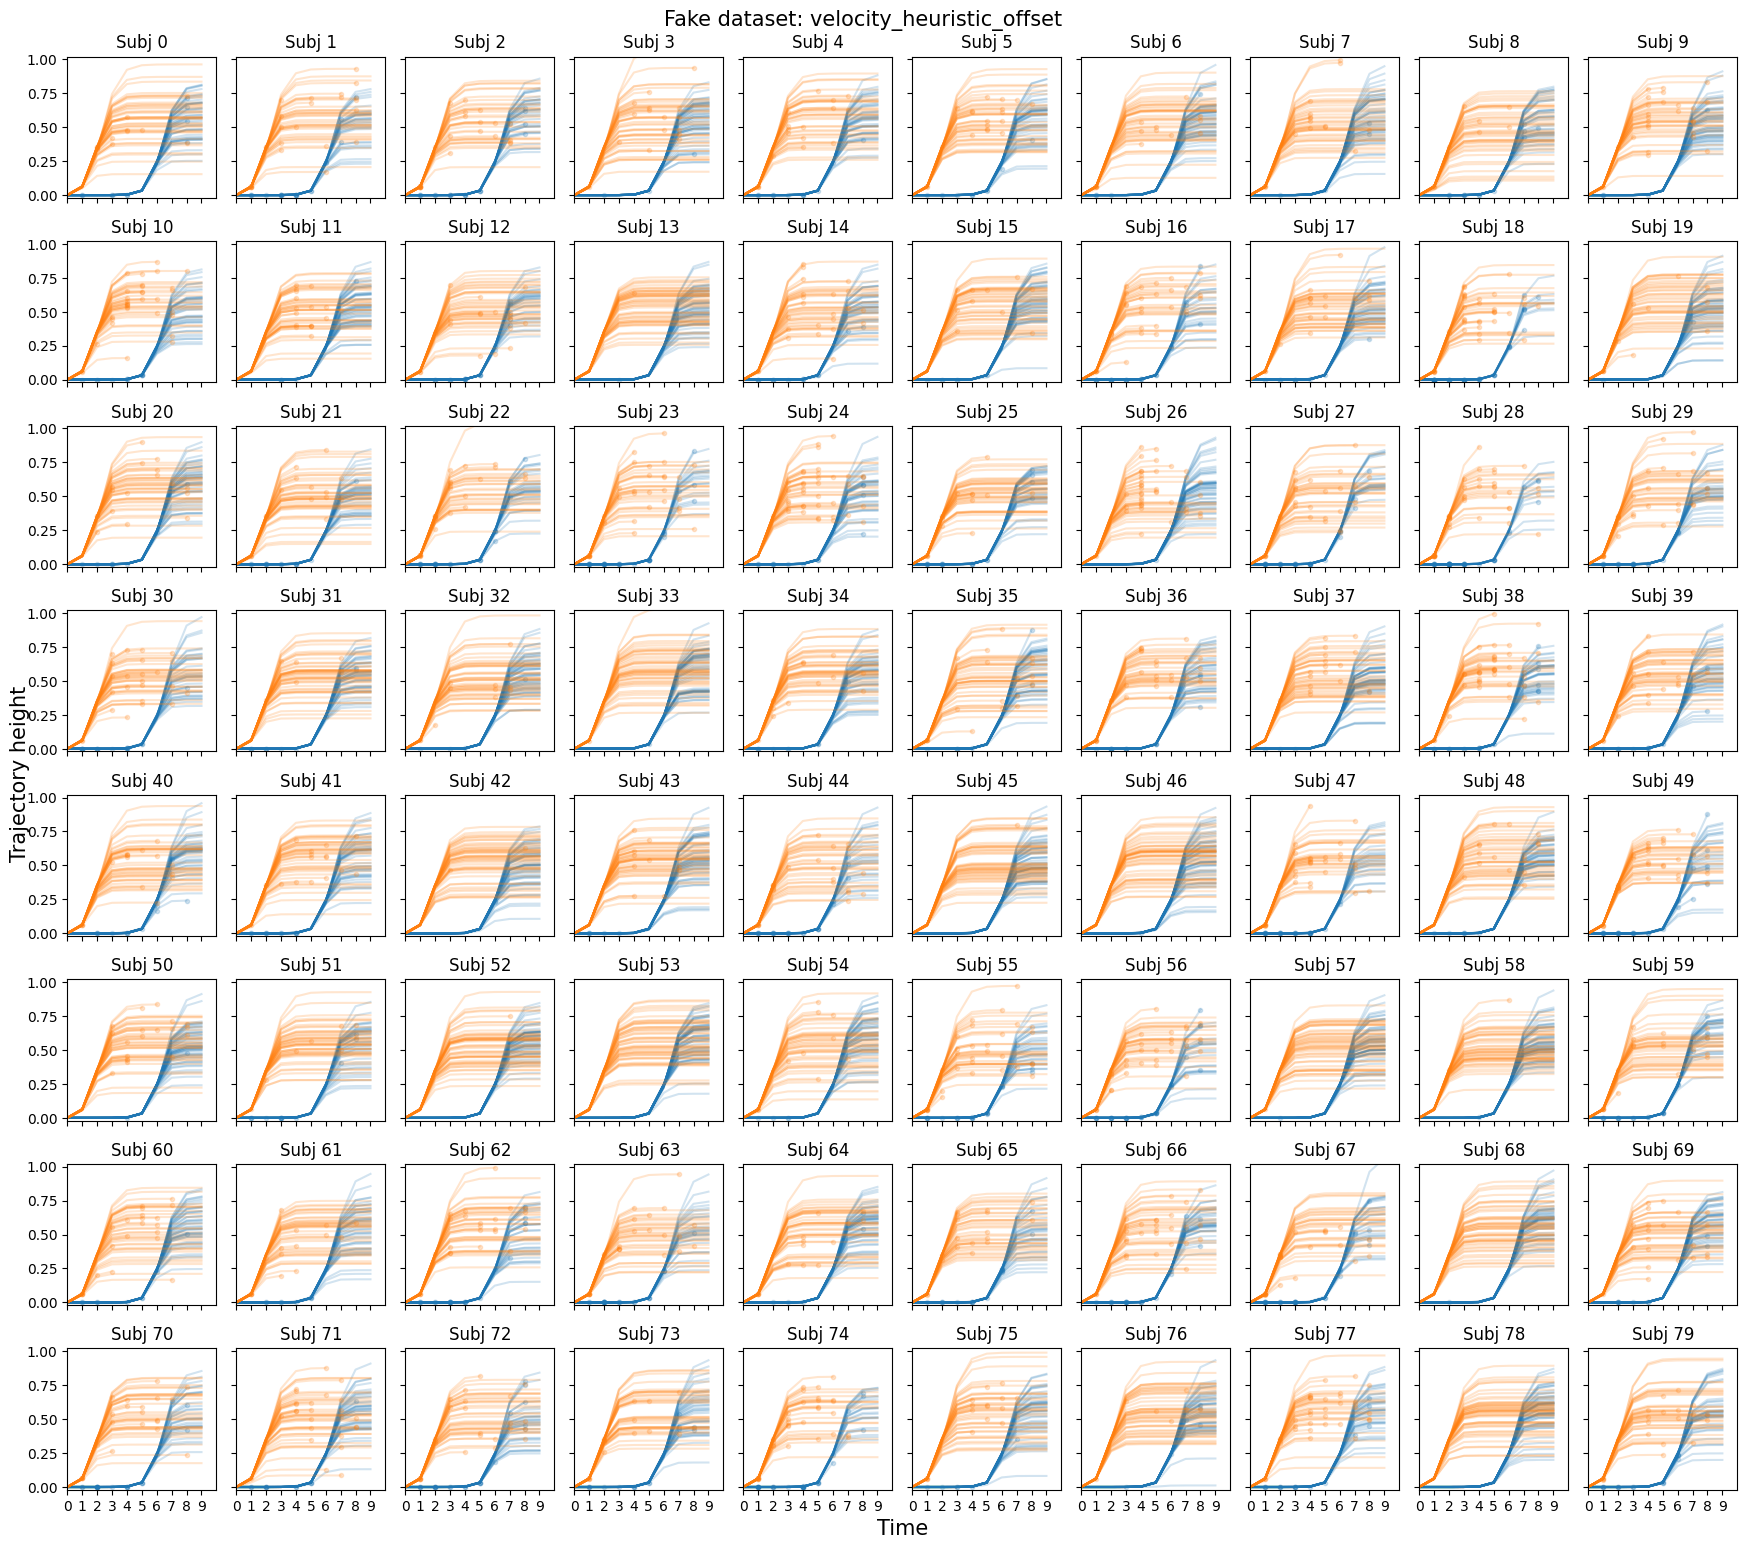

bayesian_postmean_nooffset


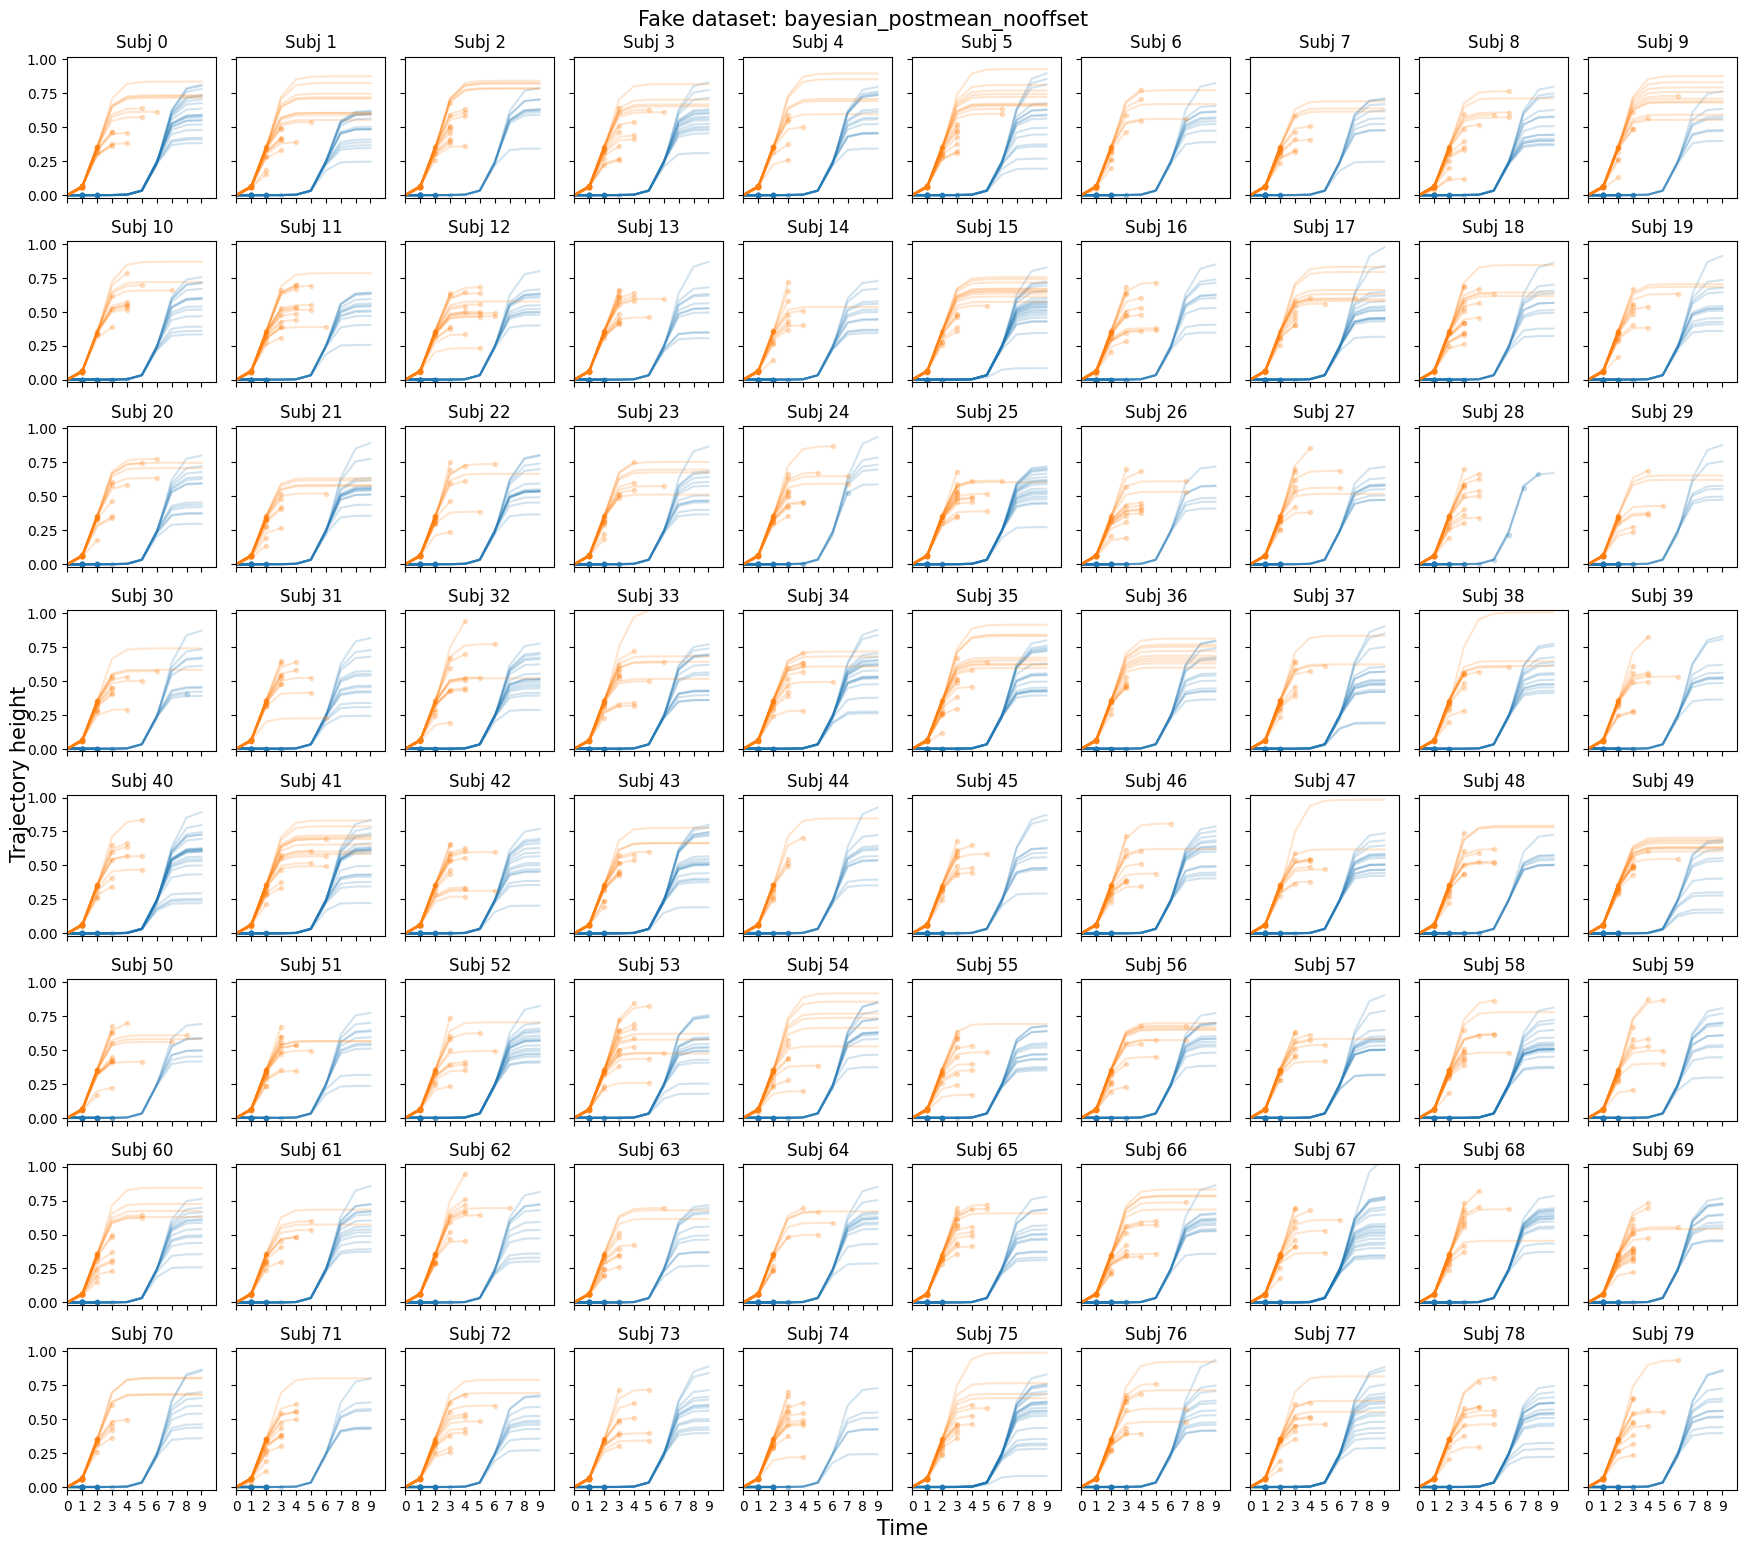

velocity_nooffset


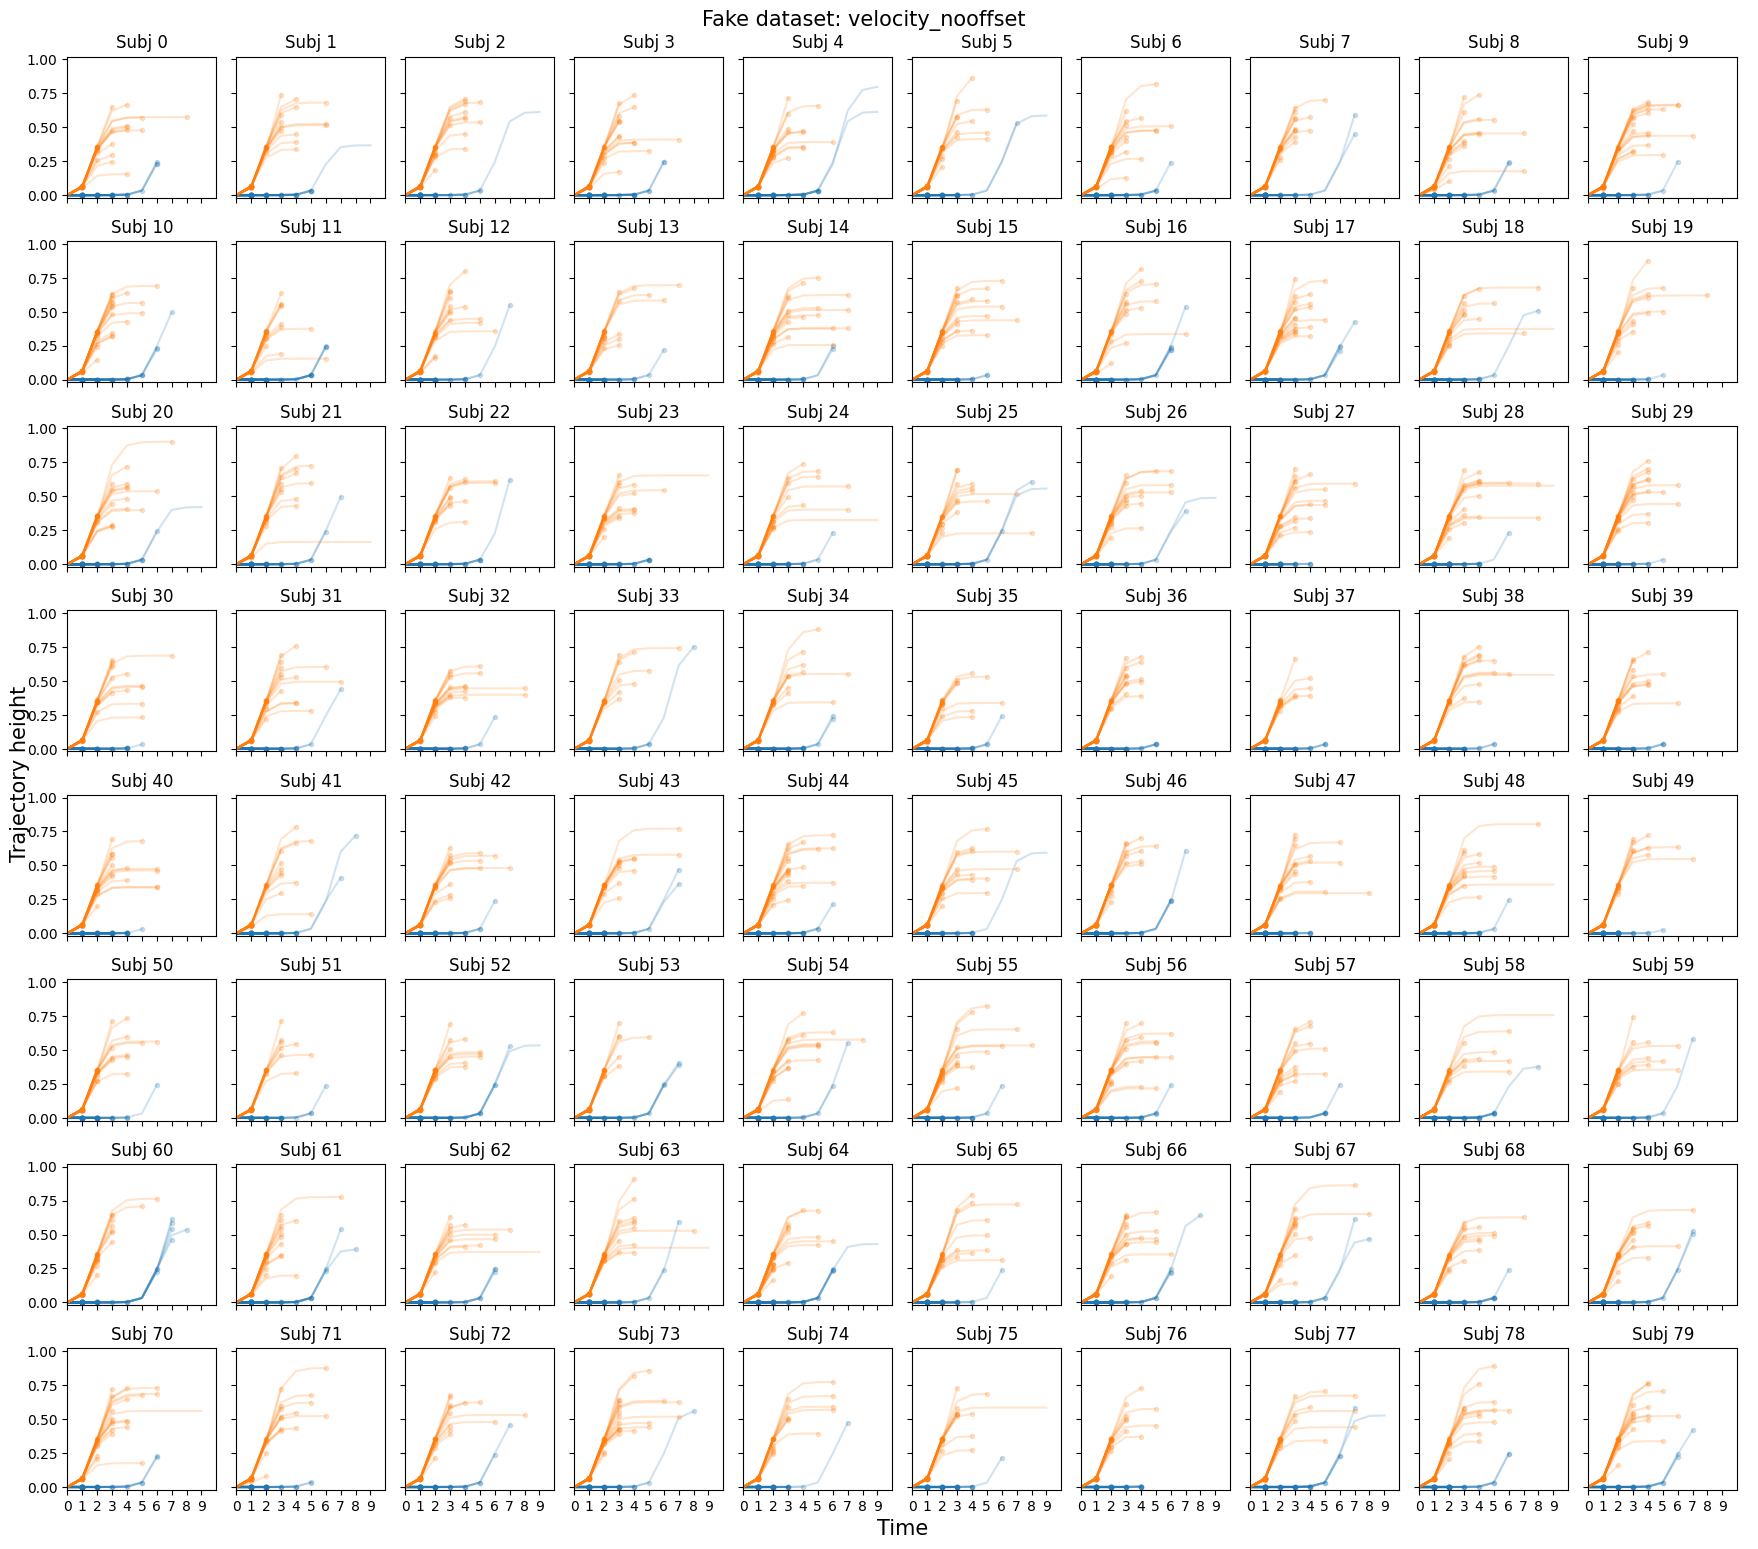

exploitation_heuristic_nooffset


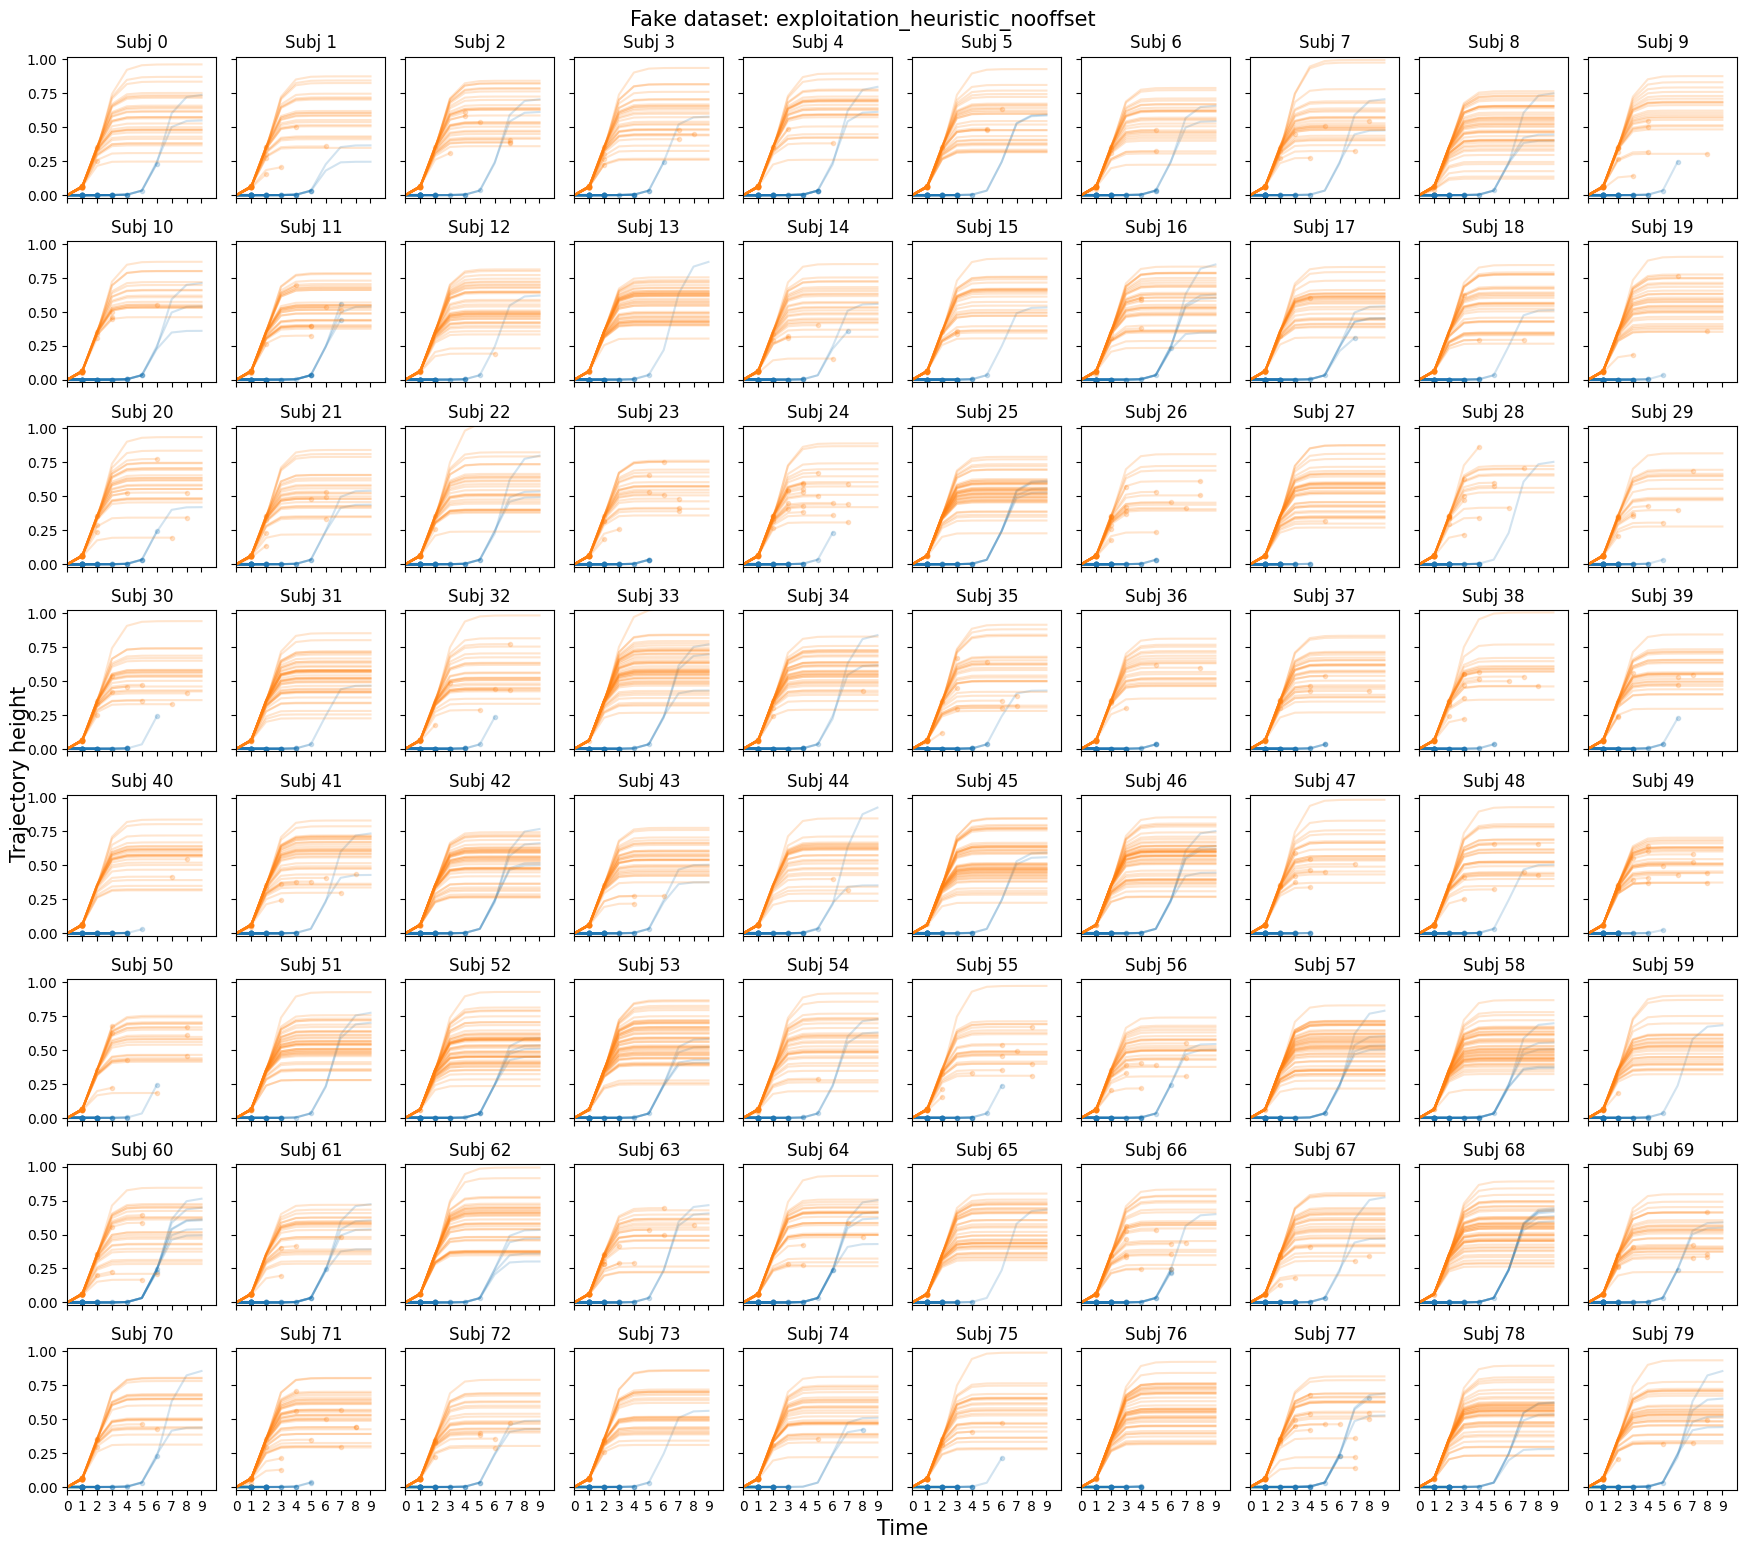

velocity_heuristic_nooffset


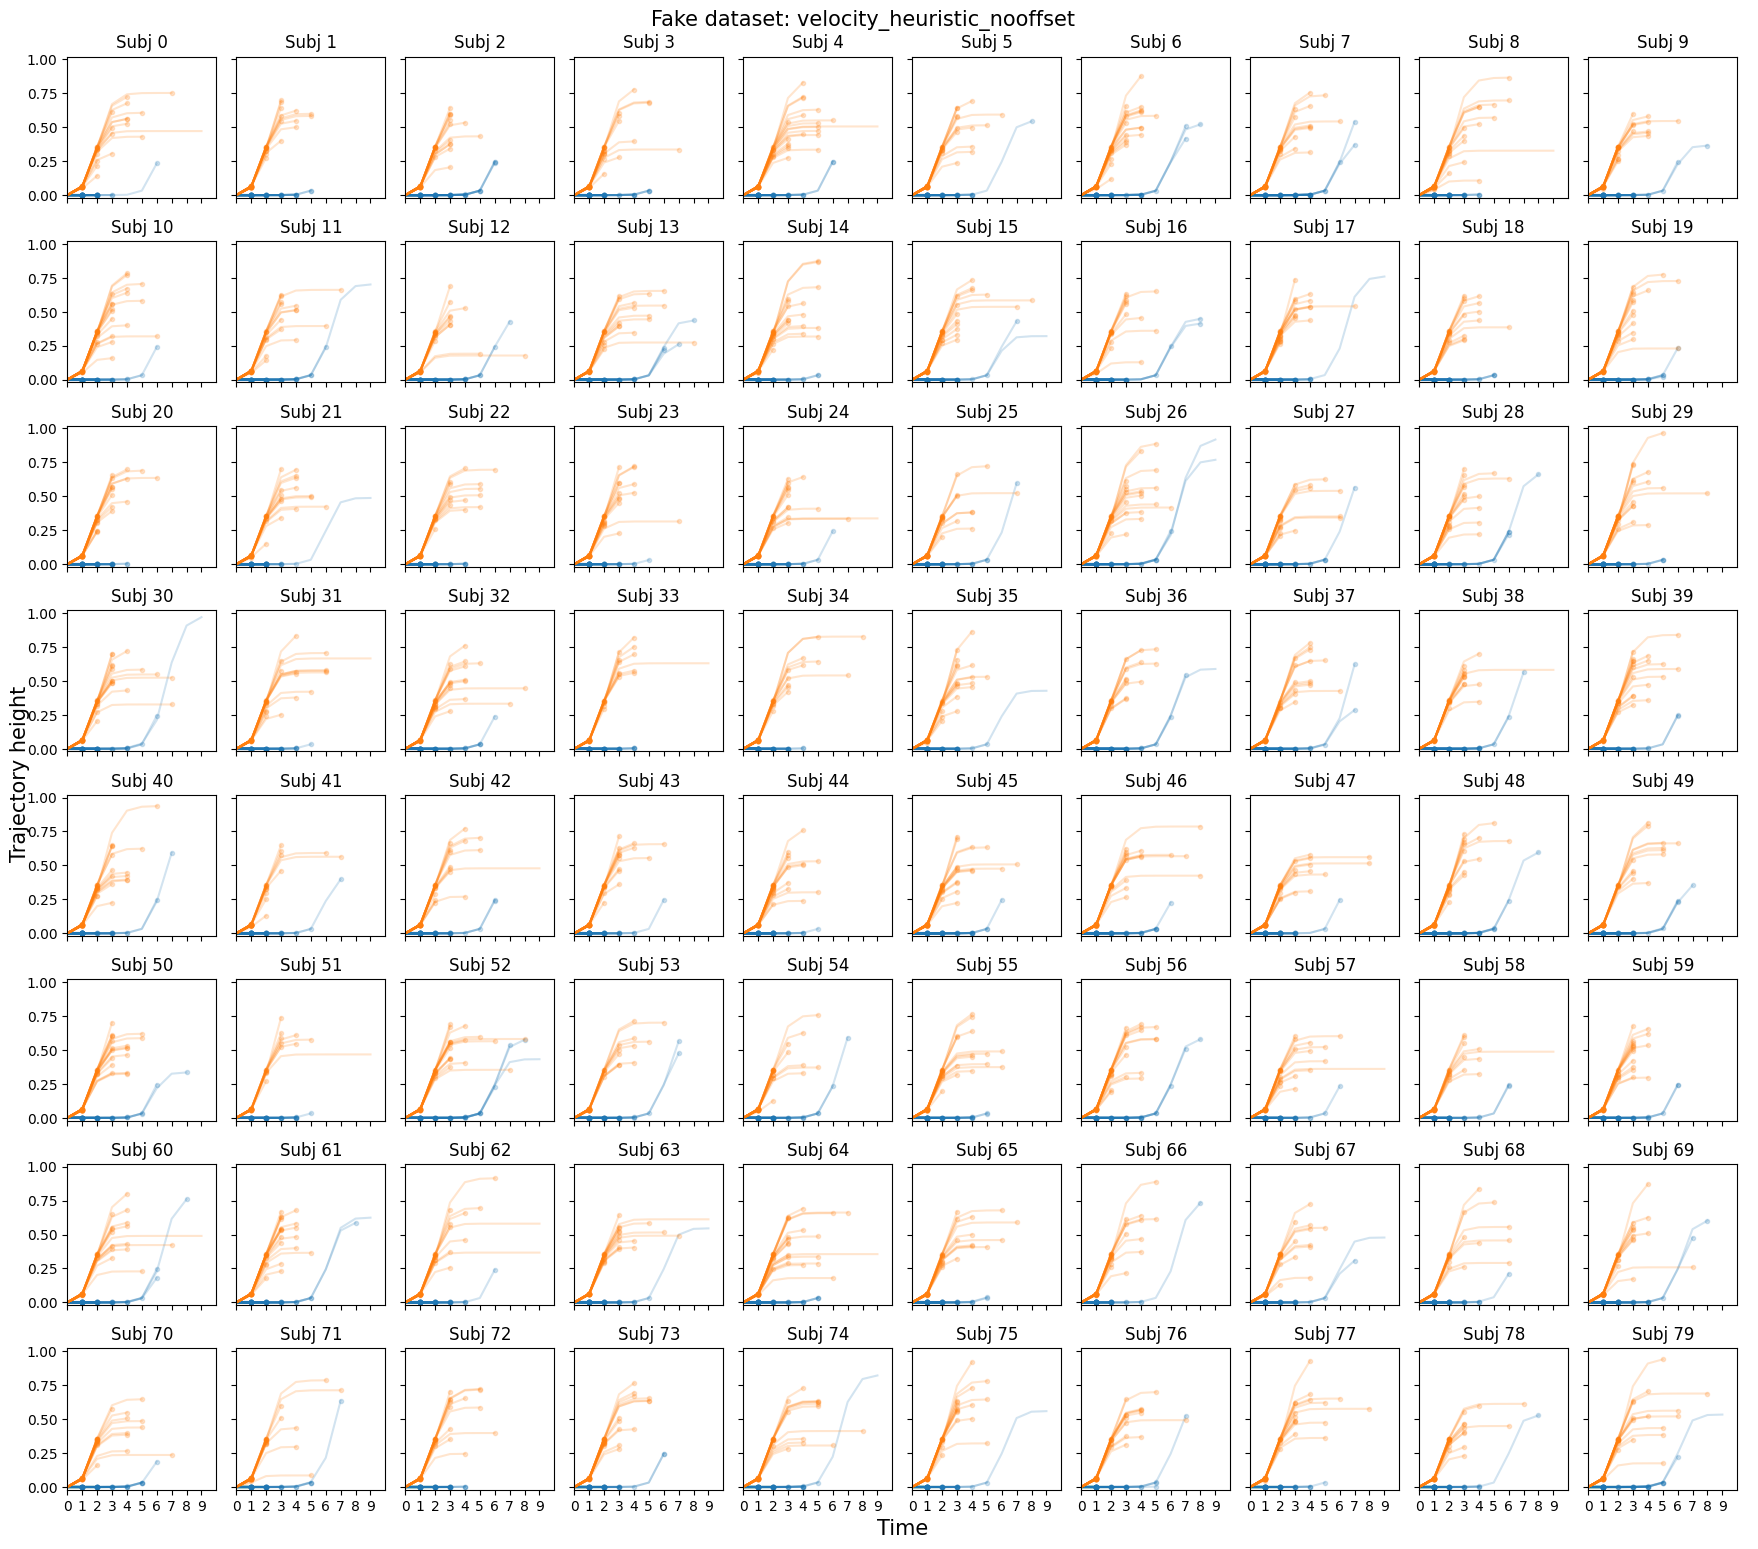

In [27]:
# Visualization of fake datasets

n_rows=8
n_cols=10

for model_fullname in model_fullnames:
    print(model_fullname)
    include_offset_param_vals = "_offset" in model_fullname
    models = model_fullname.rpartition('_')[0]
    
    fig, ax = plt.subplots(n_rows, n_cols,figsize=(18,16))
    p_continuetillends_subjmean = np.zeros((n_conds, n_subj))
    fake_data = models_fakedata[model_fullname]
    for subj in range(n_subj):
        hasswitched_subj_conds = np.zeros((n_conds, n_runs))
        for cond in range(n_conds):
            traj_heights = fake_data[cond,subj,:,:,0]
            last_free_timestep = np.isnan(traj_heights).argmax(axis=1)-1
            for run in range(n_runs):
                ax[subj//n_cols, subj%n_cols].plot(range(T_end), traj_heights[run,:], "-", color="C"+str(cond), alpha=0.2)
                ax[subj//n_cols, subj%n_cols].plot(last_free_timestep[run], np.transpose(traj_heights[run, last_free_timestep[run]]), ".", color="C"+str(cond), alpha=0.2)


        ax[subj//n_cols, subj%n_cols].set_ylim([-0.02,1.02])
        ax[subj//n_cols, subj%n_cols].set_xlim([0,10])
        ax[subj//n_cols, subj%n_cols].set_title("Subj "+str(subj))
        ax[subj//n_cols, subj%n_cols].set_xticks(range(0,T_end))

        if(subj%n_cols!=0):
            ax[subj//n_cols, subj%n_cols].set_yticklabels([])
        if(subj<n_cols*(n_rows-1)):
            ax[subj//n_cols, subj%n_cols].set_xticklabels([])

    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.ylabel("Trajectory height", fontsize=15)
    plt.xlabel("Time", fontsize=15)
    fig.suptitle("Fake dataset: "+model_fullname, fontsize=15)
    fig.tight_layout()
    #plt.savefig(os.path.join(figpath,"exp3_fakedata__"+model_fullname+"__bysubj"), dpi=300)
    plt.show()

## Evaluate CV test loss

### 1) Human data CV

In [33]:
model_fullnames = ["bayesian_postmean_offset","velocity_offset", "exploitation_heuristic_offset","velocity_heuristic_offset","bayesian_postmean_nooffset","velocity_nooffset", "exploitation_heuristic_nooffset","velocity_heuristic_nooffset"]

for model_idx in range(len(model_fullnames)):
    model_fullname = model_fullnames[model_idx]
    print(model_fullname)
    
    # 1) Load each model's CV fits on human data.
    filename = "exp3_fits_cv__d_human__m_"+model_fullname
    with open(os.path.join(fits_path, filename)+'.pickle', 'rb') as handle:
        b = pickle.load(handle)
    best_params_fitted = b["best_params_fitted"]
    data = b["data"]
    model = b["model"]
    include_offset_param = b["model_include_offset_param"]
    cross_val_setidxs_allsubjs = b["cross_val_setidxs_allsubjs"]
    if(model_idx==0):
        (n_conds, n_subj, n_runs, n_timesteps, _) = data.shape 
        crossentropy_cv_test = np.zeros((n_subj, len(model_fullnames), n_folds))
    

    # 2) Evaluate cross-validation test dataset loss.
    for subj in range(n_subj): # Just Subject 0.
        data_subj = data[:,subj,:,:,:]
        cross_val_setidxs = cross_val_setidxs_allsubjs[subj]
        for fold in range(n_folds):
            crossentropy_cv_test[subj,model_idx,fold] = crossentropy_loss(best_params_fitted[subj,0,fold,:], data_subj=data_subj, ts=ts, T_ends=T_ends, model=model, include_offset_param=include_offset_param, cross_validate=True, cross_validate_timepts=cross_val_setidxs[fold][1])


bayesian_postmean_offset


C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = np.trapz(np.exp(log_p_r_T_and_theta_given_r), x=theta0_grid, axis=-1)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:24: RuntimeWarning: divide by zero encountered in log
  log_normpdf_unnorm = -np.log(std)-0.5*np.log(2*np.pi)

velocity_offset
exploitation_heuristic_offset
velocity_heuristic_offset
bayesian_postmean_nooffset
velocity_nooffset
exploitation_heuristic_nooffset
velocity_heuristic_nooffset


In [34]:
a = {"crossentropy_cv_test":crossentropy_cv_test, "model_fullnames":model_fullnames}
filename = "exp3_cv_testlosses"
with open(os.path.join(fits_path,filename) + '.pickle', 'wb') as handle:
    pickle.dump(a, handle)

### 2) Model recovery CV

In [35]:
model_fullnames = ["bayesian_postmean_offset","velocity_offset", "exploitation_heuristic_offset","velocity_heuristic_offset","bayesian_postmean_nooffset","velocity_nooffset", "exploitation_heuristic_nooffset","velocity_heuristic_nooffset"]

first_entry = True
for fakedataset_idx in range(len(model_fullnames)):
    fakedataset_fullname = model_fullnames[fakedataset_idx]
    for model_idx in range(len(model_fullnames)):
        model_fullname = model_fullnames[model_idx]
        
        # 1) Load each model's CV fits on human data.
        filename = "exp3_fits_cv_modelrecov__d_"+fakedataset_fullname+"__m_"+model_fullname
        if(not os.path.isfile(os.path.join(fits_path, filename)+'.pickle')):
            # Model fit not yet completed
            continue;
        print(fakedataset_fullname,model_fullname)
            
        with open(os.path.join(fits_path, filename)+'.pickle', 'rb') as handle:
            b = pickle.load(handle)
        best_params_fitted = b["best_params_fitted"]
        fake_data = b["fake_dataset"]
        model = b["model"]
        include_offset_param = b["model_include_offset_param"]
        cross_val_setidxs_allsubjs = b["cross_val_setidxs_allsubjs"]
        if(first_entry):
            first_entry=False
            (n_conds, n_subj, n_runs, n_timepts, _) = fake_data.shape 
            crossentropy_cv_test = np.zeros((n_subj, len(model_fullnames), len(model_fullnames), n_folds))
            crossentropy_cv_test[:] = np.nan


        # 2) Evaluate cross-validation test dataset loss.
        for subj in range(n_subj): # Just Subject 0.
            #print(model_fullname, subj)
            data_subj = fake_data[:,subj,:,:,:]
            cross_val_setidxs = cross_val_setidxs_allsubjs[subj]
            for fold in range(n_folds):
                crossentropy_cv_test[subj,fakedataset_idx,model_idx,fold] = crossentropy_loss(best_params_fitted[subj,0,fold,:], data_subj=data_subj, ts=ts, T_ends=T_ends, model=model, include_offset_param=include_offset_param, cross_validate=True, cross_validate_timepts=cross_val_setidxs[fold][1])


bayesian_postmean_offset bayesian_postmean_offset


C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = np.trapz(np.exp(log_p_r_T_and_theta_given_r), x=theta0_grid, axis=-1)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)


bayesian_postmean_offset velocity_offset
bayesian_postmean_offset exploitation_heuristic_offset
bayesian_postmean_offset velocity_heuristic_offset
bayesian_postmean_offset bayesian_postmean_nooffset
bayesian_postmean_offset velocity_nooffset
bayesian_postmean_offset exploitation_heuristic_nooffset
bayesian_postmean_offset velocity_heuristic_nooffset
velocity_offset bayesian_postmean_offset
velocity_offset velocity_offset
velocity_offset exploitation_heuristic_offset
velocity_offset velocity_heuristic_offset
velocity_offset bayesian_postmean_nooffset
velocity_offset velocity_nooffset
velocity_offset exploitation_heuristic_nooffset
velocity_offset velocity_heuristic_nooffset
exploitation_heuristic_offset bayesian_postmean_offset
exploitation_heuristic_offset velocity_offset
exploitation_heuristic_offset exploitation_heuristic_offset
exploitation_heuristic_offset velocity_heuristic_offset
exploitation_heuristic_offset bayesian_postmean_nooffset
exploitation_heuristic_offset velocity_nooff

In [36]:
a = {"crossentropy_cv_test":crossentropy_cv_test, "model_fullnames":model_fullnames}
filename = "exp3_cv_modelrecov_testlosses"
with open(os.path.join(fits_path,filename) + '.pickle', 'wb') as handle:
    pickle.dump(a, handle)

# *Model recovery ends here*

## Behavioral signatures

In [28]:
# Load the human dataset
filename = "exp3_data"
with open(os.path.join(data_path, filename)+'.pickle', 'rb') as handle:
    b = pickle.load(handle)
print(b.keys())  
data = b['data']
traj_params = b["traj_params"]
traj_finalheights = b["counterfactual_traj_finalheights"]
(n_conds,n_subj,n_runs,n_timesteps,_) = data.shape

# Load the fake datasets
filename = os.path.join(data_path, "exp3_fits_fakedata_allmodels")
with open(filename+'.pickle', 'rb') as handle:
    b = pickle.load(handle)
models_true_gen_params = b['true_gen_params']
models_fakedata = b['models_fakedata']

dict_keys(['mturk_IDs', 'data_dims', 'data', 'traj_params', 'counterfactual_traj_finalheights', 'starting_traj_heights_counterfactual', 'ages', 'genders', 'comments'])


C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3881674395.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  b = pickle.load(handle)


In [29]:
model_fullnames = ["bayesian_postmean_offset","velocity_offset", "exploitation_heuristic_offset","velocity_heuristic_offset","bayesian_postmean_nooffset","velocity_nooffset", "exploitation_heuristic_nooffset","velocity_heuristic_nooffset"]
#model_fullnames = ["bayesian_postmean_offset","exploitation_heuristic_offset","velocity_heuristic_offset", "bayesian_postmean_nooffset","exploitation_heuristic_nooffset","velocity_heuristic_nooffset"]

first_model = True
for model_idx in range(len(model_fullnames)):
    model_fullname = model_fullnames[model_idx]
    include_offset_param = "_offset" in model_fullname
    model = model_fullname.rpartition('_')[0]
    
    filename = "exp3_fits__d_human__m_"+model_fullname
    with open(os.path.join(fits_path, filename)+'.pickle', 'rb') as handle:
        b = pickle.load(handle)
    best_params_fitted_model = b["best_params_fitted"]
    crossentropy_fitted_model = b["crossentropy_fitted"]
    print(best_params_fitted_model.shape, crossentropy_fitted_model.shape)
    (_,_,_,n_params) = best_params_fitted_model.shape
    
    if(first_model):
        first_model = False
        best_params_fitted = np.zeros((n_subj,len(model_fullnames), 3))
        crossentropy_fitted = np.zeros((n_subj,len(model_fullnames)))
    if(not include_offset_param):
        best_params_fitted[:,model_idx,0:n_params] = best_params_fitted_model[:,0,0,:]
    else:
        best_params_fitted[:,model_idx,:] = best_params_fitted_model[:,0,0,:]
    crossentropy_fitted[:,model_idx] = np.squeeze(np.min(crossentropy_fitted_model, axis=2))
        

(80, 1, 1, 3) (80, 1, 10)
(80, 1, 1, 3) (80, 1, 10)
(80, 1, 1, 3) (80, 1, 10)
(80, 1, 1, 3) (80, 1, 10)
(80, 1, 1, 2) (80, 1, 10)
(80, 1, 1, 2) (80, 1, 10)
(80, 1, 1, 2) (80, 1, 10)
(80, 1, 1, 2) (80, 1, 10)


In [30]:
# Get accuracy rates for [subj, model]

responses_allsubj = data[:,:,:,:,1] # [cond, subj, run, timept]
responses_allsubj = responses_allsubj[None,:] # [model, cond, subj, run, timept]
model_prob_preds_allsubj = np.zeros((len(model_fullnames), n_conds, n_subj, n_runs, n_timesteps))
stayswitchdiff_allsubj = np.zeros((len(model_fullnames), n_conds, n_subj, n_runs, n_timesteps))
accuracy_subjs = np.zeros((n_subj,len(model_fullnames)))
accuracy_subjs[:] = np.nan
n_subj_diverselabels = 0
for model_idx in range(len(model_fullnames)):
    model_fullname = model_fullnames[model_idx]
    print(model_fullname)
    include_offset_param = "_offset" in model_fullname
    model = model_fullname.rpartition('_')[0]
    
    for subj in range(n_subj): 
        data_subj = data[:,subj,:,:,:]
        responses_subj = data[:,subj,:,:,1] # [cond, run, timept]
        responses_subj_flat = responses_subj.flatten()
        params_fitted_temp = np.squeeze(best_params_fitted[subj,model_idx,:])
        [model_prob_preds,stayswitchdiff] = evaluate_p_stay_logistic(params_fitted_temp, data_subj=data_subj, ts=ts, T_ends=T_ends, model=model,include_offset_param=include_offset_param)
        model_prob_preds_allsubj[model_idx,:,subj,:,:] = model_prob_preds
        stayswitchdiff_allsubj[model_idx,:,subj,:,:] = stayswitchdiff
        model_prob_preds_flat = model_prob_preds.flatten()
        label_notnan = np.where(np.isnan(responses_subj_flat)==False)[0]
        accuracy_subjs[subj,model_idx] = np.mean((model_prob_preds_flat[label_notnan]>0.5)==responses_subj_flat[label_notnan])
        

bayesian_postmean_offset


C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = np.trapz(np.exp(log_p_r_T_and_theta_given_r), x=theta0_grid, axis=-1)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
C:\Users\liu_s\AppData\Local\Temp\ipykernel_31200\3618318889.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)


velocity_offset
exploitation_heuristic_offset
velocity_heuristic_offset
bayesian_postmean_nooffset
velocity_nooffset
exploitation_heuristic_nooffset
velocity_heuristic_nooffset


In [31]:
# Save the files, given that it is so slow.
a = {"responses_allsubj":responses_allsubj, "model_prob_preds_allsubj":model_prob_preds_allsubj, "stayswitchdiff_allsubj":stayswitchdiff_allsubj, "accuracy_subjs":accuracy_subjs,"model_fullnames":model_fullnames}
filename = "exp3_modelfits_logisticpredprobs"
with open(os.path.join(fits_path,filename) + '.pickle', 'wb') as handle:
    pickle.dump(a, handle)